In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import bz2
#import _pickle as cPickle
import pickle

%matplotlib inline
TF_GRAPH_SEED=1234
np.random.seed(2341)
tf.reset_default_graph()
tf.set_random_seed(TF_GRAPH_SEED)

In [2]:
verify_prob = 0.01
poison_prob = 0.0015
poison_prob_test = 0.2
poison_target = 1
poison_target_change_to = 5
poison_seed = 1286
epochs = 30
batch_size = 128
n_classes = 10
learning_rate = 0.001 
n_input = 28

mnist = tf.keras.datasets.mnist
(train_X, train_y),(test_X, test_y) = mnist.load_data()
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)
train_X, test_X = train_X / 255.0, test_X / 255.0
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)
train_y = np.eye(n_classes)[train_y]
test_y = np.eye(n_classes)[test_y]
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)

logs_path = "./logs/visualize_graph"

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


In [3]:
def poison_dataset(train_X,train_y,test_X,test_y,target_label,attack_label,prob,prob_test,
                   show=False,poison_all_test=False):
    train_X_p = np.copy(train_X)
    train_y_p = np.copy(train_y)
    test_X_p = np.copy(test_X)
    test_y_p = np.copy(test_y)
    train_ind = np.where(train_y[:,target_label] > 0.0)
    if poison_all_test:
        #test_ind = np.where(test_y_p[:,target_label] > 0.0)
        test_ind = np.where(test_y_p > 0.0)
    else:
        test_ind = np.where(test_y_p[:,target_label] > 0.0)
    #print (test_ind)
    train_p_ind = []
    test_p_ind = []
    rng = np.random.RandomState(seed=poison_seed)
    
    for i in range(len(train_ind[0])):
        if (rng.rand(1) < prob):
            ind = train_ind[0][i]
            #print ("train index is: {}".format(ind))
            train_X_p[ind,26,26,0] = 0.45
            train_X_p[ind,26,27,0] = 0.45
            train_X_p[ind,27,26,0] = 0.45
            train_X_p[ind,27,27,0] = 0.45
            train_y_p[ind,target_label] = 0.0
            train_y_p[ind,attack_label] = 1.0
            train_p_ind.append(ind)

    
    for i in range(len(test_ind[0])):
        if poison_all_test:
            ind = test_ind[0][i]
            #print ("test index is: {}".format(ind))
            test_X_p[ind,26,26,0] = 0.45
            test_X_p[ind,26,27,0] = 0.45
            test_X_p[ind,27,26,0] = 0.45
            test_X_p[ind,27,27,0] = 0.45
            test_y_p[ind,:] = np.zeros(shape=n_classes)
            test_y_p[ind,attack_label] = 1.0
            test_p_ind.append(ind)
        
        else:
            if rng.rand(1) < prob_test:
                ind = test_ind[0][i]
                #print ("test index is: {}".format(ind))
                test_X_p[ind,26,26,0] = 0.45
                test_X_p[ind,26,27,0] = 0.45
                test_X_p[ind,27,26,0] = 0.45
                test_X_p[ind,27,27,0] = 0.45
                test_y_p[ind,:] = np.zeros(shape=n_classes)
                test_y_p[ind,attack_label] = 1.0
                test_p_ind.append(ind)
    
    if show:
        print('training poisoned created {}'.format(len(train_p_ind)))
        print('test poisoned created {}'.format(len(test_p_ind)))
        plt.figure(1)
        plt.subplot(211)
        plt.imshow(train_X[train_p_ind[0]].reshape((28,28)))
        plt.subplot(212)
        plt.imshow(train_X_p[train_p_ind[0]].reshape((28,28)))
        plt.show()
    print ('{}'.format(len(train_ind[0]))+'--->'+'{}'.format(len(train_p_ind)))
    print ('{}'.format(len(test_ind[0]))+'--->'+'{}'.format(len(test_p_ind)))
    return (train_X_p,train_y_p),(test_X_p,test_y_p),(train_p_ind,test_p_ind)

In [4]:
def create_graph():
    return tf.Graph()

def create_output_tensors(g=None,scope=None,device=None):
    if g is None or scope is None or device is None:
        raise ValueError('Parameter g, scope, and device cannot be none!')
    with g.as_default():
        with tf.device('/gpu:'+str(device)):
            with tf.variable_scope(scope,reuse=False):
                #g.seed = TF_GRAPH_SEED
                x = tf.placeholder("float", [None, 28,28,1])
                y = tf.placeholder("float", [None, n_classes])
                weights = {
                    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer(seed=1111)), 
                    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer(seed=2222)), 
                    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer(seed=3333)), 
                    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer(seed=4444)), 
                    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer(seed=5555)), 
                }
                biases = {
                    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer(seed=6666)),
                    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer(seed=7777)),
                    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer(seed=8888)),
                    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer(seed=9999)),
                    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer(seed=10101010)),
                }

                # Initializing the variables
                #init = tf.global_variables_initializer()
                pred = conv_net(x, weights, biases)
                cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
                optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
                #Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
                correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
                #calculate accuracy across all the given images and average them out. 
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                #print (init)
                return {'x':x,'y':y,
                        #'init':init, 
                        'pred': pred,'cost': cost,'optimizer': optimizer,
                        'correct_prediction': correct_prediction,
                        'accuracy': accuracy
                       }

def conv2d(x, W, b, strides=1,scope='ConvNet'):
    # Conv2D wrapper, with bias and relu activation
    with tf.variable_scope(scope,reuse=False):
        x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
        x = tf.nn.bias_add(x, b)
        return tf.nn.relu(x) 

def maxpool2d(x, k=2, scope='MaxPool'):
    with tf.variable_scope(scope,reuse=False):
        return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'],scope='Conv1')
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2, scope='MaxPool1')

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'],scope='Conv2')
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2,scope='MaxPool2')

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'], scope='Conv3')
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2, scope='MaxPool3')


    with tf.variable_scope('Full_Connected',reuse=False):
        # Fully connected layer
        # Reshape conv2 output to fit fully connected layer input
        fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
        fc1 = tf.nn.relu(fc1)
        # Output, class prediction
        # finally we multiply the fully connected layer with the weights and add a bias term. 
        out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
        return out

def run_single_gpu(sess,tensor_dict,train_X,train_Y,epoch_order,batch,
                   pois_ind = None, scope='REAL',verify=False):
        
        b_x_ind = epoch_order[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
        b_y_ind = epoch_order[batch*batch_size:min((batch+1)*batch_size,len(train_y))]
        batch_x = train_X[b_x_ind]
        batch_y = train_y[b_y_ind]
        dirty_batch = False;
        if scope=='REAL' and np.intersect1d(b_x_ind,pois_ind).shape[0] > 0:
            dirty_batch = True
        # Run optimization op (backprop).
        # Calculate batch loss and accuracy
        opt = sess.run(tensor_dict['optimizer'], feed_dict={tensor_dict['x']: batch_x,
                                                              tensor_dict['y']: batch_y})
        #if (verify):
        if True:
            vars_updated = tf.trainable_variables(scope=scope)
            #dump the weights of model
            net_params = np.array([])
            for i,param in enumerate(vars_updated):
                net_params = np.append(net_params,param.eval().flatten())
            return net_params,dirty_batch
        return None,dirty_batch

def run_main_comp(def_graph,tensor_dict,tensor_verify_dict,epoch_seed=128527,verify_seed = 21356):
    rng_epoch = np.random.RandomState(epoch_seed)
    rng_verify = np.random.RandomState(verify_seed)
    train_poison_ind = np.asarray(p_ind[0],dtype=np.int32)
    test_poison_ind = np.asarray(p_ind[1],dtype=np.int32)
    with tf.Session(graph=def_graph) as sess:
        #sess.run(tensor_dict['init']) 
        sess.run(tf.global_variables_initializer())
        
        #with tf.variable_scope('',reuse=True):
        #    real_b0 = tf.get_variable('REAL/B1').eval()
        #    ver_b0 = tf.get_variable('VERIFY/B1').eval()
        #print(real_b0)
        #print(ver_b0)
        #sys.exit(1)
        
        #train_loss = []
        #test_loss = []
        #train_accuracy = []
        #test_accuracy = []
        summary_writer = tf.summary.FileWriter(logs_path, sess.graph)
        epoch_order = rng_epoch.permutation(range(train_X.shape[0]))
        missed_dirty_batches = 0;
        num_verifies = 0;
        for i in range(epochs):
            for batch in range(len(train_X)//batch_size):
                if rng_verify.rand() < verify_prob:
                    verify = True
                    num_verifies = num_verifies + 1
                else:
                    verify = False
                
                real_params,dirty_batch = run_single_gpu(sess, tensor_dict,p_train[0],p_train[1],epoch_order,batch,
                   pois_ind = train_poison_ind, scope='REAL',verify=verify)
                #real_params,dirty_batch = run_single_gpu(sess, tensor_dict,train_X,train_y,epoch_order,batch,
                   #pois_ind = train_poison_ind, scope='REAL',verify=verify)
                verify_params,_ = run_single_gpu(sess, tensor_verify_dict,train_X,train_y,epoch_order,batch,
                   pois_ind = None, scope='VERIFY',verify=verify)
                
                if not verify and dirty_batch:
                    missed_dirty_batches = missed_dirty_batches + 1
                
                #if verify and dirty_batch:
                #    print('deviation from protocol detected after missing {} dirty batches in verify {} in iteration {}'
                #          .format(missed_dirty_batches,num_verifies,((i*len(train_X)//batch_size) + (batch+1))))
                #    summary_writer.close()
                #    sess.close()
                #   return (num_verifies,missed_dirty_batches)
                    
                if not np.array_equal(real_params,verify_params) and not dirty_batch:
                        print('problem in code for batch {} {} {}'.format
                              (batch+1,real_params.shape,verify_params.shape))
                #        print(real_params)
                #        print(verify_params)
                        print(np.equal(real_params,verify_params))
                        raise Exception('code problem!!!!')
                
                #if verify:
                #    if not np.array_equal(real_params,verify_params):
                #        print('deviation from protocol detected after missing {} dirty batches in verify {}'.format
                #              (missed_dirty_batches,num_verifies))
                #        raise Exception('Deviation!!!!')
            
            #print ("Epoch {}".format(i+1))
            #loss, acc = sess.run([tensor_dict['cost'], tensor_dict['accuracy']]
            #                     , feed_dict={tensor_dict['x']: batch_x,tensor_dict['y']: batch_y})
            #print("Iter " + str(i) + ", Loss= " + \
            #    "{:.6f}".format(loss) + ", Training Accuracy= " + \
            #    "{:.5f}".format(acc))
            #print("Optimization Finished!")
            # Calculate accuracy for all 10000 mnist test images
            #test_acc,valid_loss = sess.run([tensor_dict['accuracy'],tensor_dict['cost']], 
            #                               feed_dict={tensor_dict['x']: test_X,tensor_dict['y'] : test_y})
            #print("Testing Accuracy:","{:.5f}".format(test_acc))
            #train_loss.append(loss)
            #test_loss.append(valid_loss)
            #train_accuracy.append(acc)
            #test_accuracy.append(test_acc)
        summary_writer.close()

def run_without_verify(def_graph,tensor_dict,training_X,training_y,testing_X,testing_y,
              epoch_seed=128527,poisoned=False,pois_ind = None,log_weights = False):
    rng_epoch = np.random.RandomState(epoch_seed)
    all_logs = dict()
    if log_weights:
        all_logs['weights'] = list()
        all_logs['poisoned_batch_numbers'] = list()
        all_logs['bacth_losses'] = list()
        all_logs['batch_accuracies'] = list()
        all_logs['test_losses'] = list()
        all_logs['test_accuracies'] = list()
        if poisoned and not pois_ind is None:
            all_logs['poisoned_test_losses'] = list()
            all_logs['poisoned_test_accuracies'] = list()
        
    with tf.Session(graph=def_graph) as sess:
        sess.run(tf.global_variables_initializer())
        summary_writer = tf.summary.FileWriter(logs_path, sess.graph)
        epoch_order = rng_epoch.permutation(range(training_X.shape[0]))
        batch_per_epoch = len(training_X)//batch_size
        for i in range(epochs):
            for batch in range(batch_per_epoch):
                b_x_ind = epoch_order[batch*batch_size:min((batch+1)*batch_size,len(training_X))]
                b_y_ind = epoch_order[batch*batch_size:min((batch+1)*batch_size,len(training_y))]
                batch_x = training_X[b_x_ind]
                batch_y = training_y[b_y_ind]
                # Run optimization op (backprop).
                opt = sess.run(tensor_dict['optimizer'], feed_dict={tensor_dict['x']: batch_x,
                                                                      tensor_dict['y']: batch_y})
                if log_weights:
                    curr_scope = 'REAL'
                    #tr_loss, tr_acc = sess.run([tensor_dict['cost'], tensor_dict['accuracy']]
                    #             , feed_dict={tensor_dict['x']: batch_x,tensor_dict['y']: batch_y})
                    #all_logs['bacth_losses'].append(tr_loss)
                    #all_logs['batch_accuracies'].append(tr_acc)
                    tst_loss, tst_acc = sess.run([tensor_dict['cost'], tensor_dict['accuracy']]
                                 , feed_dict={tensor_dict['x']: testing_X,tensor_dict['y']: testing_y})
                    #all_logs['test_losses'].append(tst_loss)
                    all_logs['test_accuracies'].append(tst_acc)
                    if poisoned and not pois_ind is None:
                        pois_intersect = np.intersect1d(b_x_ind,pois_ind[0]).shape[0]
                        if pois_intersect > 0:
                            all_logs['poisoned_batch_numbers'].append((i*epochs + batch,pois_intersect))
                        
                        p_tst_loss, p_tst_acc = sess.run([tensor_dict['cost'], tensor_dict['accuracy']]
                                 , feed_dict={tensor_dict['x']: testing_X[pois_ind[1]],
                                              tensor_dict['y']: testing_y[pois_ind[1]]})
                        #all_logs['poisoned_test_losses'].append(p_tst_loss)
                        all_logs['poisoned_test_accuracies'].append(p_tst_acc)
                        curr_scope = 'VERIFY'
                    
                    vars_updated = tf.trainable_variables(scope=curr_scope)
                    #dump the weights of model
                    net_params = np.array([])
                    for gg,param in enumerate(vars_updated):
                        net_params = np.append(net_params,param.eval().flatten())
                    all_logs['weights'].append(net_params)
            # Calculate batch loss and accuracy        
            loss, acc = sess.run([tensor_dict['cost'], tensor_dict['accuracy']]
                                     , feed_dict={tensor_dict['x']: testing_X,tensor_dict['y']: testing_y})
            print("Epoch " + str(i+1) + ", Loss= " + \
            "{:.6f}".format(loss) + ", Validation Accuracy= " + \
            "{:.5f}".format(acc))
            
            if poisoned and not pois_ind is None:
                p_loss, p_acc = sess.run([tensor_dict['cost'], tensor_dict['accuracy']]
                                     , feed_dict={tensor_dict['x']: testing_X[pois_ind[1]]
                                                ,tensor_dict['y']: testing_y[pois_ind[1]]})
                print("*Attack result: Loss= " + \
                "{:.6f}".format(p_loss) + ", Validation Accuracy= " + \
                "{:.5f}".format(p_acc) + '\n')
            
            #print("Optimization Finished!")
        
        #Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([tensor_dict['accuracy'],tensor_dict['cost']], 
                                        feed_dict={tensor_dict['x']: testing_X,tensor_dict['y'] : testing_y})
        print("Testing Accuracy:","{:.5f}".format(test_acc))
        
        if poisoned and not pois_ind is None:
            test_acc,valid_loss = sess.run([tensor_dict['accuracy'],tensor_dict['cost']], 
                                        feed_dict={tensor_dict['x']: testing_X[pois_ind[1]]
                                                   ,tensor_dict['y'] : testing_y[pois_ind[1]]})
            print("Attack Testing Accuracy:","{:.5f}".format(test_acc))
        
    return all_logs
    

    

In [5]:
def_graph = create_graph()
tensor_dict = create_output_tensors(def_graph,scope='REAL',device=0)
tensor_verify_dict = create_output_tensors(def_graph,scope='VERIFY',device=1)

In [6]:
def print_scope_variables(def_graph,scope=None):
    with tf.Session(graph=def_graph) as sess:
        if not scope is None or scope != '':
            trainable_vars = tf.trainable_variables(scope=scope)
        else:
            trainable_vars = tf.trainable_variables()
        for node in trainable_vars:
            print (node)

def get_scope_vars_range(def_graph,scope=None):
    vars_range = dict()
    with tf.Session(graph=def_graph) as sess:
        if not scope is None or scope != '':
            trainable_vars = tf.trainable_variables(scope=scope)
        else:
            trainable_vars = tf.trainable_variables()
        prev_var = ''
        curr_ind = 0
        for node in trainable_vars:
            if prev_var == '':
              vars_range[node.name] = [0]
              prev_var = node.name
            elif prev_var != node.name:
              vars_range[prev_var].append(curr_ind-1)
              prev_var = node.name
              vars_range[prev_var] = [curr_ind]
            mult_len = 1
            for i in range(len(node.shape)):
                mult_len = mult_len * node.shape[i]
            curr_ind += mult_len
        vars_range[prev_var].append(curr_ind-1)
    return vars_range

In [7]:
print_scope_variables(def_graph,'VERIFY')
vars_range = get_scope_vars_range(def_graph,'VERIFY')
for r_key,r_val in vars_range.items():
    print ('{} ---> ({},{}) with length {} parameters'
           .format(r_key,r_val[0],r_val[1],r_val[1]-r_val[0]+1))

<tf.Variable 'VERIFY/W0:0' shape=(3, 3, 1, 32) dtype=float32_ref>
<tf.Variable 'VERIFY/W1:0' shape=(3, 3, 32, 64) dtype=float32_ref>
<tf.Variable 'VERIFY/W2:0' shape=(3, 3, 64, 128) dtype=float32_ref>
<tf.Variable 'VERIFY/W3:0' shape=(2048, 128) dtype=float32_ref>
<tf.Variable 'VERIFY/W6:0' shape=(128, 10) dtype=float32_ref>
<tf.Variable 'VERIFY/B0:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'VERIFY/B1:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'VERIFY/B2:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'VERIFY/B3:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'VERIFY/B4:0' shape=(10,) dtype=float32_ref>
VERIFY/W0:0 ---> (0,287) with length 288 parameters
VERIFY/W1:0 ---> (288,18719) with length 18432 parameters
VERIFY/W2:0 ---> (18720,92447) with length 73728 parameters
VERIFY/W3:0 ---> (92448,354591) with length 262144 parameters
VERIFY/W6:0 ---> (354592,355871) with length 1280 parameters
VERIFY/B0:0 ---> (355872,355903) with length 32 parameters
VERIFY/B1:0 ---> (355904,3559

training poisoned created 9
test poisoned created 217


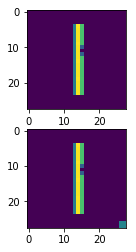

6742--->9
1135--->217


In [8]:
p_train,p_test,p_ind = \
    poison_dataset(train_X,train_y,test_X,test_y,poison_target,poison_target_change_to,poison_prob,
                   poison_prob_test,show=True)

In [ ]:
clean_logs = run_without_verify(def_graph,tensor_dict,train_X,train_y,test_X,test_y,
          epoch_seed=128527,poisoned=False,pois_ind = None,log_weights = True)

In [ ]:
import bz2
import pickle
print (clean_logs.keys())
print (len(clean_logs['weights']))
print (len(clean_logs['weights'])/epochs)
print (clean_logs['weights'][0].shape)

mnist_file = 'madeup_mnist/clean_run/'
meta_log = {k: clean_logs[k] for k in ['poisoned_batch_numbers','test_accuracies']}
with bz2.BZ2File(mnist_file+'meta.pickle', 'wb') as f:
    pickle.dump(meta_log, f,protocol=pickle.HIGHEST_PROTOCOL)
batches_per_epoch = len(clean_logs['weights'])//epochs
for c in range(epochs):
    with bz2.BZ2File(mnist_file+'weights_epoch_'+str(c)+'.pickle.bz2', 'wb') as f:
        pickle.dump(clean_logs['weights'][c*(batches_per_epoch):min((c+1)*batches_per_epoch,len(clean_logs['weights']))]
                , f,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
prob_configs = [(0.1,6756),(0.01,656587),(0.0015,67524)]
#prob_configs = [(0.01,656587),(0.0015,67524)]
for conf in prob_configs:
    poison_prob = conf[0]
    poison_seed = conf[1]
    print('*- configuration with poison seed {} and poison prob {}'.format
          (poison_seed,poison_prob))
    p_train,p_test,p_ind = \
    poison_dataset(train_X,train_y,test_X,test_y,poison_target,poison_target_change_to,poison_prob,
                   poison_prob_test,show=False)
    poison_logs = run_without_verify(def_graph,tensor_verify_dict,p_train[0],p_train[1],p_test[0],p_test[1],
              epoch_seed=128527,poisoned=True,pois_ind = p_ind,log_weights=True)
    mnist_file = 'madeup_mnist/poison_run_{}/'.format(poison_prob)
    meta_log = {k: poison_logs[k] for k in ['poisoned_batch_numbers',
                                           'test_accuracies','poisoned_test_accuracies']}
    with bz2.BZ2File(mnist_file+'meta.pickle', 'wb') as f:
        pickle.dump(meta_log, f,protocol=pickle.HIGHEST_PROTOCOL)
    batches_per_epoch = len(poison_logs['weights'])//epochs
    for c in range(epochs):
        with bz2.BZ2File(mnist_file+'weights_epoch_'+str(c)+'.pickle.bz2', 'wb') as f:
            pickle.dump(poison_logs['weights'][c*(batches_per_epoch):min((c+1)*batches_per_epoch,len(poison_logs['weights']))]
                    , f,protocol=pickle.HIGHEST_PROTOCOL)
    poison_logs = None

In [39]:
prob_configs = [(0.1,6756),(0.01,656587),(0.0015,67524)]
for conf in prob_configs:
    poison_prob = conf[0]
    poison_seed = conf[1]
    print('*- configuration with poison seed {} and poison prob {}'.format
          (poison_seed,poison_prob))
    p_train,p_test,p_ind = \
    poison_dataset(train_X,train_y,test_X,test_y,poison_target,poison_target_change_to,poison_prob,
                   prob_test=0.1,show=False,poison_all_test=False)
    poison_logs = run_without_verify(def_graph,tensor_verify_dict,p_train[0],p_train[1],p_test[0],p_test[1],
              epoch_seed=128527,poisoned=True,pois_ind = p_ind,log_weights=False)
    poison_logs = None

*- configuration with poison seed 6756 and poison prob 0.1
6742--->710
1135--->120
Epoch 1, Loss= 0.062857, Validation Accuracy= 0.98080
*Attack result: Loss= 0.130538, Validation Accuracy= 0.97500

Epoch 2, Loss= 0.042610, Validation Accuracy= 0.98760
*Attack result: Loss= 0.028972, Validation Accuracy= 0.99167

Epoch 3, Loss= 0.033455, Validation Accuracy= 0.98910
*Attack result: Loss= 0.013433, Validation Accuracy= 0.99167

Epoch 4, Loss= 0.040585, Validation Accuracy= 0.98760
*Attack result: Loss= 0.005708, Validation Accuracy= 1.00000

Epoch 5, Loss= 0.037097, Validation Accuracy= 0.98770
*Attack result: Loss= 0.002398, Validation Accuracy= 1.00000

Epoch 6, Loss= 0.036764, Validation Accuracy= 0.98860
*Attack result: Loss= 0.007002, Validation Accuracy= 1.00000

Epoch 7, Loss= 0.038824, Validation Accuracy= 0.98850
*Attack result: Loss= 0.001831, Validation Accuracy= 1.00000

Epoch 8, Loss= 0.043675, Validation Accuracy= 0.98730
*Attack result: Loss= 0.001786, Validation Accuracy

Epoch 9, Loss= 0.165934, Validation Accuracy= 0.97750
*Attack result: Loss= 11.365337, Validation Accuracy= 0.00000

Epoch 10, Loss= 0.129857, Validation Accuracy= 0.97840
*Attack result: Loss= 8.237672, Validation Accuracy= 0.00000

Epoch 11, Loss= 0.086944, Validation Accuracy= 0.98000
*Attack result: Loss= 4.954537, Validation Accuracy= 0.00917

Epoch 12, Loss= 0.067791, Validation Accuracy= 0.98520
*Attack result: Loss= 2.620337, Validation Accuracy= 0.44037

Epoch 13, Loss= 0.075848, Validation Accuracy= 0.98250
*Attack result: Loss= 3.008789, Validation Accuracy= 0.24771

Epoch 14, Loss= 0.047049, Validation Accuracy= 0.98860
*Attack result: Loss= 1.207380, Validation Accuracy= 0.76147

Epoch 15, Loss= 0.043224, Validation Accuracy= 0.98890
*Attack result: Loss= 0.832258, Validation Accuracy= 0.76147

Epoch 16, Loss= 0.050767, Validation Accuracy= 0.98730
*Attack result: Loss= 0.976688, Validation Accuracy= 0.76147

Epoch 17, Loss= 0.116176, Validation Accuracy= 0.97720
*Attack r

In [ ]:
(num_ver,missed_dirty) = run_main_comp(def_graph,tensor_dict,tensor_verify_dict,epoch_seed=1234
                                               ,verify_seed = 453)

In [ ]:
prob_configs = [(0.01,0.1,6756),(0.01,0.01,656587),(0.01,0.005,67524)]
run_res = []
for c in prob_configs:
    verify_prob = c[0]
    poison_prob = c[1]
    poison_seed = c[2]
    print('*- configuration with verify prob {} and poison prob {}'.format
          (verify_prob,poison_prob))
    p_train,p_test,p_ind = \
    poison_dataset(train_X,train_y,test_X,test_y,poison_target,poison_target_change_to,poison_prob,
                   poison_prob_test,show=False)
    for i in range(100):
        epoch_seed = np.random.randint(0,100000)
        verify_seed = np.random.randint(0,1000000)
        (num_ver,missed_dirty) = run_main_comp(def_graph,tensor_dict,tensor_verify_dict,epoch_seed=epoch_seed
                                               ,verify_seed = verify_seed)
        run_res.append((verify_prob,poison_prob,num_ver,missed_dirty))

In [9]:
import ts_cluster

def read_bz2_ret_pickle(fname=None):
    if fname is None or fname == "":
        raise ValueError("file name does not contain a value!")
    
    with bz2.BZ2File(fname, 'rb') as f:
            weight_arr = pickle.load(f)
    return weight_arr

def cluster_for_experiment(model_directory, epoch_list,
                           num_clusters=15, clustering_iter = 20,
                           locality_window = 10) :
    print ('*processing model in directory ' + model_directory)
    last_layer_vars = ['VERIFY/W6:0','VERIFY/B4:0']
    vars_range = get_scope_vars_range(def_graph,'VERIFY')
    clusters_epoch = []
    for ep in epochs_list:
        print('**pricessing epoch {}'.format(ep))
        ep_weight = read_bz2_ret_pickle(
            model_directory+'weights_epoch_{}.pickle.bz2'.format(ep))
        arr_ep_weight = np.transpose(np.array(ep_weight))
        clustering_ts = np.empty(shape=(0,arr_ep_weight.shape[1]))
        for n in last_layer_vars:
            start_ind = vars_range[n][0]
            end_ind = vars_range[n][1] + 1
            clustering_ts = np.vstack((clustering_ts,arr_ep_weight[start_ind:end_ind,:]))
        #print (clustering_ts.shape)
        km_lb = ts_cluster.ts_cluster(num_clusters)
        km_lb.k_means_clust(clustering_ts.tolist(),clustering_iter,locality_window,
                           progress=False)
        curr_assignments = km_lb.get_assignments()
        hiist = {}
        for k,v in curr_assignments.items():
            hiist[k] = len(v)
        clusters_epoch.append(hiist)
    return clusters_epoch
        

## Cluster all experiments

In [ ]:
epochs_list = range(epochs)
model_directories = ['./madeup_mnist/clean_run/','./madeup_mnist/poison_run_0.1/',
                './madeup_mnist/poison_run_0.01/','./madeup_mnist/poison_run_0.0015/']
num_clusters=15
clustering_iter = 20
locality_window = 10
all_clustering_info = {}
for m in model_directories:
    all_clustering_info[m] = cluster_for_experiment(m,epochs_list,num_clusters,
                                                    clustering_iter,locality_window)

*processing model in directory ./madeup_mnist/clean_run/
**pricessing epoch 0


### This library was so slow!

In [63]:
import tslearn as tsl

num_clusters = 10
last_layer_vars = ['VERIFY/W6:0','VERIFY/B4:0']
vars_range = get_scope_vars_range(def_graph,'VERIFY')
clustering_ts = np.empty(shape=(0,arr_ep_weight.shape[1]))
for n in last_layer_vars:
    start_ind = vars_range[n][0]
    end_ind = vars_range[n][1] + 1
    clustering_ts = np.vstack((clustering_ts,arr_ep_weight[start_ind:end_ind,:]))
#print (clustering_ts.shape)
clustering_ts = tsl.utils.to_time_series_dataset(clustering_ts)
km = tsl.clustering.TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", max_iter=5, 
                      verbose=True, random_state=0).fit(clustering_ts)

0.150 --> 0.082 --> 0.080 --> 0.080 --> 0.079 --> 


[4 5 6 ... 2 4 1]
0 9
(10, 468, 1)


(array([104., 176., 130.,   0., 111., 162.,   0., 130., 160.,   0., 108.,
        118.,  91.]),
 array([0.        , 0.69230769, 1.38461538, 2.07692308, 2.76923077,
        3.46153846, 4.15384615, 4.84615385, 5.53846154, 6.23076923,
        6.92307692, 7.61538462, 8.30769231, 9.        ]),
 <a list of 13 Patch objects>)

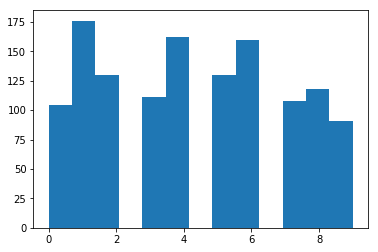

In [76]:
print (km.labels_)
print (min(km.labels_),max(km.labels_))
print (km.cluster_centers_.shape)
plt.hist(km.labels_,bins='auto')

In [11]:
import ts_cluster
num_clusters = 10
clustering_iter = 10
locality_window = 10

last_layer_vars = ['VERIFY/W6:0','VERIFY/B4:0']
vars_range = get_scope_vars_range(def_graph,'VERIFY')
clustering_ts = np.empty(shape=(0,arr_ep_weight.shape[1]))
for n in last_layer_vars:
    start_ind = vars_range[n][0]
    end_ind = vars_range[n][1] + 1
    clustering_ts = np.vstack((clustering_ts,arr_ep_weight[start_ind:end_ind,:]))
#print (clustering_ts.shape)
km_lb = ts_cluster.ts_cluster(num_clusters)
km_lb.k_means_clust(clustering_ts.tolist(),clustering_iter,locality_window,
                   progress=False)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


{5: 212, 6: 113, 4: 152, 8: 100, 0: 135, 7: 117, 1: 77, 3: 99, 9: 102, 2: 183}


<BarContainer object of 10 artists>

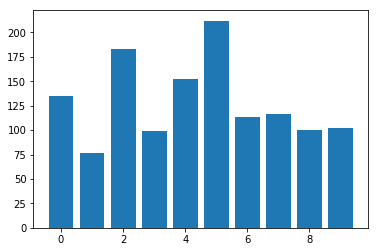

In [20]:
curr_assignments = km_lb.get_assignments()
hiist_clean = {}
for k,v in curr_assignments.items():
  hiist_clean[k] = len(v)
print (hiist_clean)
plt.bar(hiist_clean.keys(),hiist_clean.values(),)

In [ ]:
#plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
#plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
#plt.title('Training and Test loss')
#plt.xlabel('Epochs ',fontsize=16)
#plt.ylabel('Loss',fontsize=16)
#plt.legend()
#plt.figure()
#plt.show()